In [4]:
## yolov3 help https://machinelearningspace.com/yolov3-tensorflow-2-part-1/

!wget --header="Host: pjreddie.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" "https://pjreddie.com/media/files/yolov3.weights" -c -O 'yolov3.weights'

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img , img_to_array
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import *
import re

In [6]:
def parse_cfg(cfgfile):
    with open(cfgfile, 'r') as file:
        lines = [line.rstrip('\n') for line in file if line != '\n' and line[0] != '#']
    holder = {}
    blocks = []
    for line in lines:
        if line[0] == '[':
            line = 'type=' + line[1:-1].rstrip()
            if len(holder) != 0:
                blocks.append(holder)
                holder = {}
        key, value = line.split("=")
        holder[key.rstrip()] = value.lstrip()
    blocks.append(holder)
    return blocks

# parse_cfg("yolov3.cfg")

In [27]:
def YOLOv3Network(cfgfile, model_size, num_classes):
    blocks = parse_cfg(cfgfile)
    outputs = {}
    output_filters = []
    filters = []
    out_pred = []
    scale = 0
    inputs = input_image = Input(shape=model_size)
    inputs = inputs / 255.0

    for i, block in enumerate(blocks[1:]):
      ## if we get a convolutional layer
      if block['type'] == "convolutional":
        activation = block['activation']
        batch_normalize= 1 if 'batch_normalize' in block else 0
        filters = int(block['filters'])
        kernel_size = int(block['size'])
        stride = int(block['stride'])

        if stride > 1:
          inputs = ZeroPadding2D(((1,0),(0,1)))(inputs)
        
        inputs = Conv2D(filters,kernel_size=kernel_size,
                        strides=stride,
                        padding = "valid" if stride >1 else "same",
                        name=f"Conv_{i}",
                        use_bias=False if batch_normalize else True)(inputs)
        
        if batch_normalize:
          inputs = BatchNormalization(name=f"batch_norm_{i}")(inputs)
          inputs = LeakyReLU(alpha=0.1,name=f"LeakyRelu_{i}")(inputs)
      
      ## if we get an upsample layer
      elif  block['type'] == "upsample":
        stride = int(block['stride'])
        inputs = UpSampling2D(stride)(inputs)
      
      ## if we get a route layer
      elif block['type'] == "route":
        layers = [int(k) for k in block['layers'].split(",")]
        start = layers[0]

        if len(layers) > 1:
          end = layers[1] - i
          filters = output_filters[i+start] + output_filters[end]
          inputs = tf.concat([outputs[i + start], outputs[i + end]], axis=-1)
        else:
          filters = output_filters[i+start]
          inputs = outputs[i+start]
      
      elif block['type'] == "shortcut":
        from_ = int(block['from'])
        inputs = outputs[i-1] + outputs[i + from_]
      
      elif block['type'] == "yolo":
        mask = [int(k) for k in block['mask'].split(',')]
        anchors = [int(a) for a in block['anchors'].split(",")]
        anchors = [(anchors[k],anchors[k]) for k in range(0,len(anchors),2)]
        anchors = [anchors[k] for k in mask]
        num_anchors = len(anchors)


        out_shape = inputs.get_shape().as_list()
        inputs = tf.reshape(inputs, [-1, num_anchors * out_shape[1] * out_shape[2],5 + num_classes])
        
        box_centers = inputs[:, :, 0:2]
        box_shapes = inputs[:, :, 2:4]
        confidence = inputs[:, :, 4:5]
        classes = inputs[:, :, 5:num_classes + 5]

        box_centers = tf.sigmoid(box_centers)
        confidence = tf.sigmoid(confidence)
        classes = tf.sigmoid(classes)

        anchors = tf.tile(anchors,[out_shape[1]*out_shape[2],1])
        box_shapes = tf.exp(box_shapes)*tf.cast(anchors,dtype=tf.float32)

        x = tf.range(out_shape[1], dtype=tf.float32)
        y = tf.range(out_shape[2], dtype=tf.float32)
        cx, cy = tf.meshgrid(x, y)
        cx = tf.reshape(cx, (-1, 1))
        cy = tf.reshape(cy, (-1, 1))
        cxy = tf.concat([cx, cy], axis=-1)
        cxy = tf.tile(cxy, [1, num_anchors])
        cxy = tf.reshape(cxy, [1, -1, 2])
        strides = (input_image.shape[1] // out_shape[1], \
                    input_image.shape[2] // out_shape[2])
        box_centers = (box_centers + cxy) * strides

        prediction = tf.concat([box_centers, box_shapes, confidence, classes], axis=-1)

        if scale:
          out_pred = tf.concat([out_pred, prediction], axis=1)
        else:
          out_pred = prediction
          scale = 1
        
      outputs[i] = inputs
      output_filters.append(filters)

    model = Model(input_image, out_pred)
    # model.summary()
    return model

In [62]:
# model = YOLOv3Network('yolov3.cfg',(416,416,3),80)
# tf.keras.utils.plot_model(model,show_shapes=True,dpi=96)

In [30]:
len(model.layers)

294

In [41]:
## weights convertor

def load_weights(weightsfile,config_file , model):
  fp = open(weightsfile,'rb')
  np.fromfile(fp,dtype=np.int32,count=5)
  
  blocks = parse_cfg(config_file)

  for i, block in enumerate(blocks[1:]):
    if block['type'] == "convolutional":
      conv_layer = model.get_layer(f"Conv_{i}")

      # print(f"Layer {i+1} Convolutional Layer")

      filters = conv_layer.filters
      kernel_size = conv_layer.kernel_size[0]
      input_dims = conv_layer.input_shape[-1]

      if 'batch_normalize' in block:
        norm_layer = model.get_layer(f"batch_norm_{i}")  
        size = np.prod(norm_layer.get_weights()[0].shape)
        
        bn_weights = np.fromfile(fp,dtype=np.float32,count = 4*filters)
        bn_weights = bn_weights.reshape((4,filters))[[1,0,2,3,]]

      else :
        conv_bias = np.fromfile(fp,dtype=np.float32,count=filters)
      

      conv_shape = (filters,input_dims,kernel_size,kernel_size)
      conv_weights = np.fromfile(fp,dtype=np.float32,
                                 count = np.product(conv_shape))
    
      conv_weights = conv_weights.reshape(conv_shape).transpose([2,3,1,0])
    
      if 'batch_normalize' in block:
        norm_layer.set_weights(bn_weights) 
        conv_layer.set_weights([conv_weights])
      else :
        conv_layer.set_weights([conv_weights,conv_bias])
      
  assert len(fp.read()) == 0, 'failed to read all data'
  fp.close()

In [42]:
weightfile = "yolov3.weights"
cfgfile = "yolov3.cfg"
model_size = (416, 416, 3)
num_classes = 80
model=YOLOv3Network(cfgfile,model_size,num_classes)
load_weights(weightfile,cfgfile,model)
try:
    model.save_weights('weights/yolov3_weights.tf')
    print('\nThe file \'yolov3_weights.tf\' has been saved successfully.')
except IOError:
    print("Couldn't write the file \'yolov3_weights.tf\'.")

Layer 1 Convolutional Layer
Layer 2 Convolutional Layer
Layer 3 Convolutional Layer
Layer 4 Convolutional Layer
Layer 6 Convolutional Layer
Layer 7 Convolutional Layer
Layer 8 Convolutional Layer
Layer 10 Convolutional Layer
Layer 11 Convolutional Layer
Layer 13 Convolutional Layer
Layer 14 Convolutional Layer
Layer 15 Convolutional Layer
Layer 17 Convolutional Layer
Layer 18 Convolutional Layer
Layer 20 Convolutional Layer
Layer 21 Convolutional Layer
Layer 23 Convolutional Layer
Layer 24 Convolutional Layer
Layer 26 Convolutional Layer
Layer 27 Convolutional Layer
Layer 29 Convolutional Layer
Layer 30 Convolutional Layer
Layer 32 Convolutional Layer
Layer 33 Convolutional Layer
Layer 35 Convolutional Layer
Layer 36 Convolutional Layer
Layer 38 Convolutional Layer
Layer 39 Convolutional Layer
Layer 40 Convolutional Layer
Layer 42 Convolutional Layer
Layer 43 Convolutional Layer
Layer 45 Convolutional Layer
Layer 46 Convolutional Layer
Layer 48 Convolutional Layer
Layer 49 Convolutiona

In [44]:
def non_max_suppression(inputs, model_size, max_output_size, 
                        max_output_size_per_class, iou_threshold, confidence_threshold):
 
    bbox, confs, class_probs = tf.split(inputs, [4, 1, -1], axis=-1)
    bbox=bbox/model_size[0]
    scores = confs * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=max_output_size_per_class,
        max_total_size=max_output_size,
        iou_threshold=iou_threshold,
        score_threshold=confidence_threshold
    )
    return boxes, scores, classes, valid_detections

def resize_image(inputs, modelsize):
    inputs= tf.image.resize(inputs, modelsize)
    return inputs

def load_class_names(file_name):
    with open(file_name, 'r') as f:
        class_names = f.read().splitlines()
    return class_names

def output_boxes(inputs,model_size, max_output_size, max_output_size_per_class, 
                 iou_threshold, confidence_threshold):
    center_x, center_y, width, height, confidence, classes = \
        tf.split(inputs, [1, 1, 1, 1, 1, -1], axis=-1)
    top_left_x = center_x - width / 2.0
    top_left_y = center_y - height / 2.0
    bottom_right_x = center_x + width / 2.0
    bottom_right_y = center_y + height / 2.0
    inputs = tf.concat([top_left_x, top_left_y, bottom_right_x,
                        bottom_right_y, confidence, classes], axis=-1)
    boxes_dicts = non_max_suppression(inputs, model_size, max_output_size, 
                                      max_output_size_per_class, iou_threshold, confidence_threshold)
    return boxes_dicts

def draw_outputs(img, boxes, objectness, classes, nums, class_names):
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    boxes=np.array(boxes)
    for i in range(nums):
        x1y1 = tuple((boxes[i,0:2] * [img.shape[1],img.shape[0]]).astype(np.int32))
        x2y2 = tuple((boxes[i,2:4] * [img.shape[1],img.shape[0]]).astype(np.int32))
        img = cv2.rectangle(img, (x1y1), (x2y2), (255,0,0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
                          (x1y1), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)
    return img

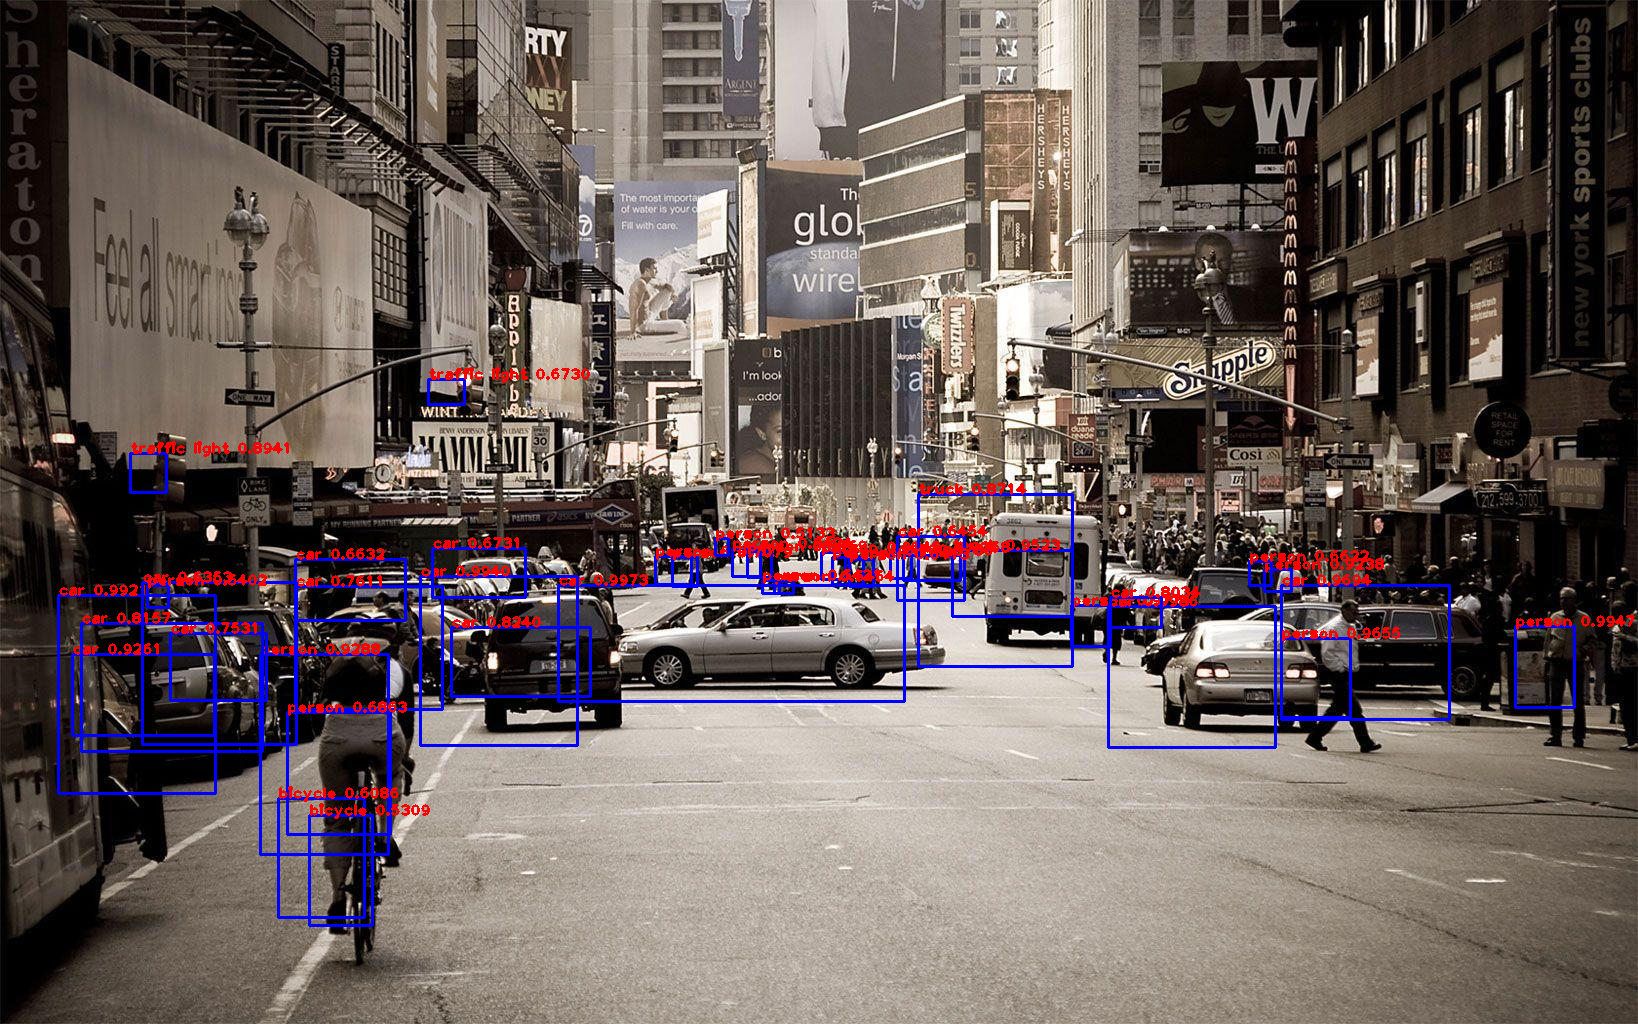

In [61]:
import cv2

model_size = (1024 ,1024 ,3)
num_classes = 80
class_name = '/content/coco.names'
max_output_size = 50
max_output_size_per_class= 40
iou_threshold = 0.5
confidence_threshold = 0.5
cfgfile = 'yolov3.cfg'
weightfile = 'weights/yolov3_weights.tf'
img_path = "sample3.jpg"

model = YOLOv3Network(cfgfile,model_size,num_classes)
model.load_weights(weightfile)

class_names = load_class_names(class_name)

image = cv2.imread(img_path)

image = np.array(image)
image = tf.expand_dims(image, 0)

resized_frame = resize_image(image, (model_size[0],model_size[1]))
pred = model.predict(resized_frame)

boxes, scores, classes, nums = output_boxes( \
    pred, model_size,
    max_output_size=max_output_size,
    max_output_size_per_class=max_output_size_per_class,
    iou_threshold=iou_threshold,
    confidence_threshold=confidence_threshold)

image = np.squeeze(image)
img = draw_outputs(image, boxes, scores, classes, nums, class_names)
win_name = 'Image detection'

#If you want to save the result, uncommnent the line below:
# cv2.imwrite('test.jpg', img)
from google.colab.patches import cv2_imshow
cv2_imshow(img)